## Libraries

In [13]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Data

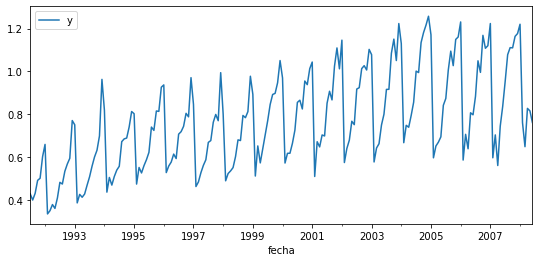

In [19]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax)
ax.legend();

## Time series cross-validation

In [20]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

cv_forecaster(
        forecaster  = forecaster,
        y           = data,
        steps       = 10,
        metric      = 'mean_squared_error',
        initial_train_size    = int(len(data)*0.5),
        allow_incomplete_fold = True,
        verbose     = True
    )

Number of folds: 11
Since `allow_incomplete_fold=True`, last fold only includes 2 observations instead of 10.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.


array([0.00422291, 0.00634336, 0.01092581, 0.00483358, 0.00746501,
       0.0048392 , 0.01333912, 0.00597068, 0.00616372, 0.00881862,
       0.00677257])

## Backtest

In [26]:
# Backtest forecaster
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data,
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 11
    Number of steps per fold: 10
    Last fold only includes 9 observations
 Error de backtest: [0.01823166]


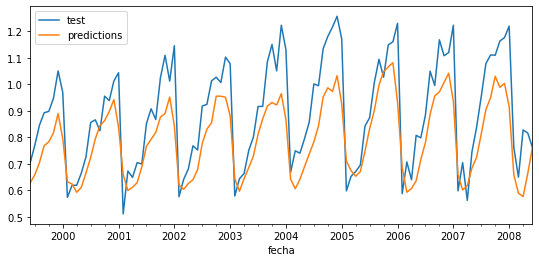

In [30]:
# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=data_test.index)
fig, ax = plt.subplots(figsize=(9, 4))
data_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

## Backtest with prediction intervals

In [31]:
# Backtest forecaster
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data,
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    interval   = [5, 95],
                                    n_boot     = 500,
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 11
    Number of steps per fold: 10
    Last fold only includes 9 observations
Error de backtest: [0.01823166]


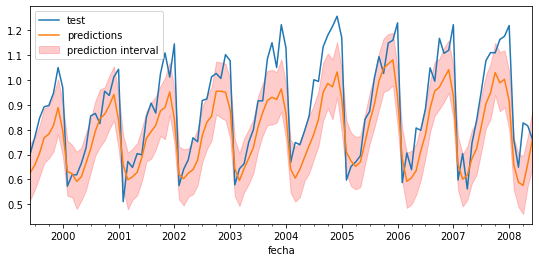

In [34]:
predictions_backtest = pd.DataFrame(data=predictions_backtest, index=data_test.index)
fig, ax=plt.subplots(figsize=(9, 4))
data_test.plot(ax=ax, label='test')
predictions_backtest.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions_backtest.index,
    predictions_backtest.iloc[:, 1],
    predictions_backtest.iloc[:, 2],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
ax.legend();